# SIR modelling - finding age group parameters

## Install packages

In [8]:
# https://www.twilio.com/blog/2017/02/an-easy-way-to-read-and-write-to-a-google-spreadsheet-in-python.html
# Created by Jeremy Cruz - https://code.sololearn.com/c4gmt97Se5f9/?ref=app

import subprocess
import sys

def install(package):
    subprocess.call([
        sys.executable, "-m", "pip", "-q", "install", package
    ])

install('gspread')
install('oauth2client')

## Define global helper functions

In [47]:
# Title, color, vaccination percentage, population count
titles = [
    ['Whole population', '#FFFF00', 0.755, 5822763],
    ['0 - 9', '#228b22', 0, 614489],
    ['10 - 19', '#ffdab9', 0.595, 681911],
    ['20 - 29', '#00008b', 0.74, 782701],
    ['30 - 39', '#b03060', 0.76, 686808],
    ['40 - 49', '#ff0000', 0.87, 756048],
    ['50 - 59', '#ffa500', 0.916, 800444],
    ['60 - 69', '#00ff00', 0.95, 663646],
    ['70 - 79', '#00ffff', 0.96, 564390],
    ['80 - 89', '#ff00ff', 0.965, 227298],
    ['90+', '#1e90ff', 0.95, 45027]
]

def convert_to_int(list):
    return [int(item) for item in list]

def get_age_group_title(age_group_index):
    return titles[age_group_index][0]

def get_age_group_color(age_group_index):
    return titles[age_group_index][1]

def get_age_group_vac_per(age_group_index):
    return titles[age_group_index][2]

def get_age_group_population(age_group_index):
    return titles[age_group_index][3]
    

## Graph parameters for all age groups

<IPython.core.display.Javascript object>


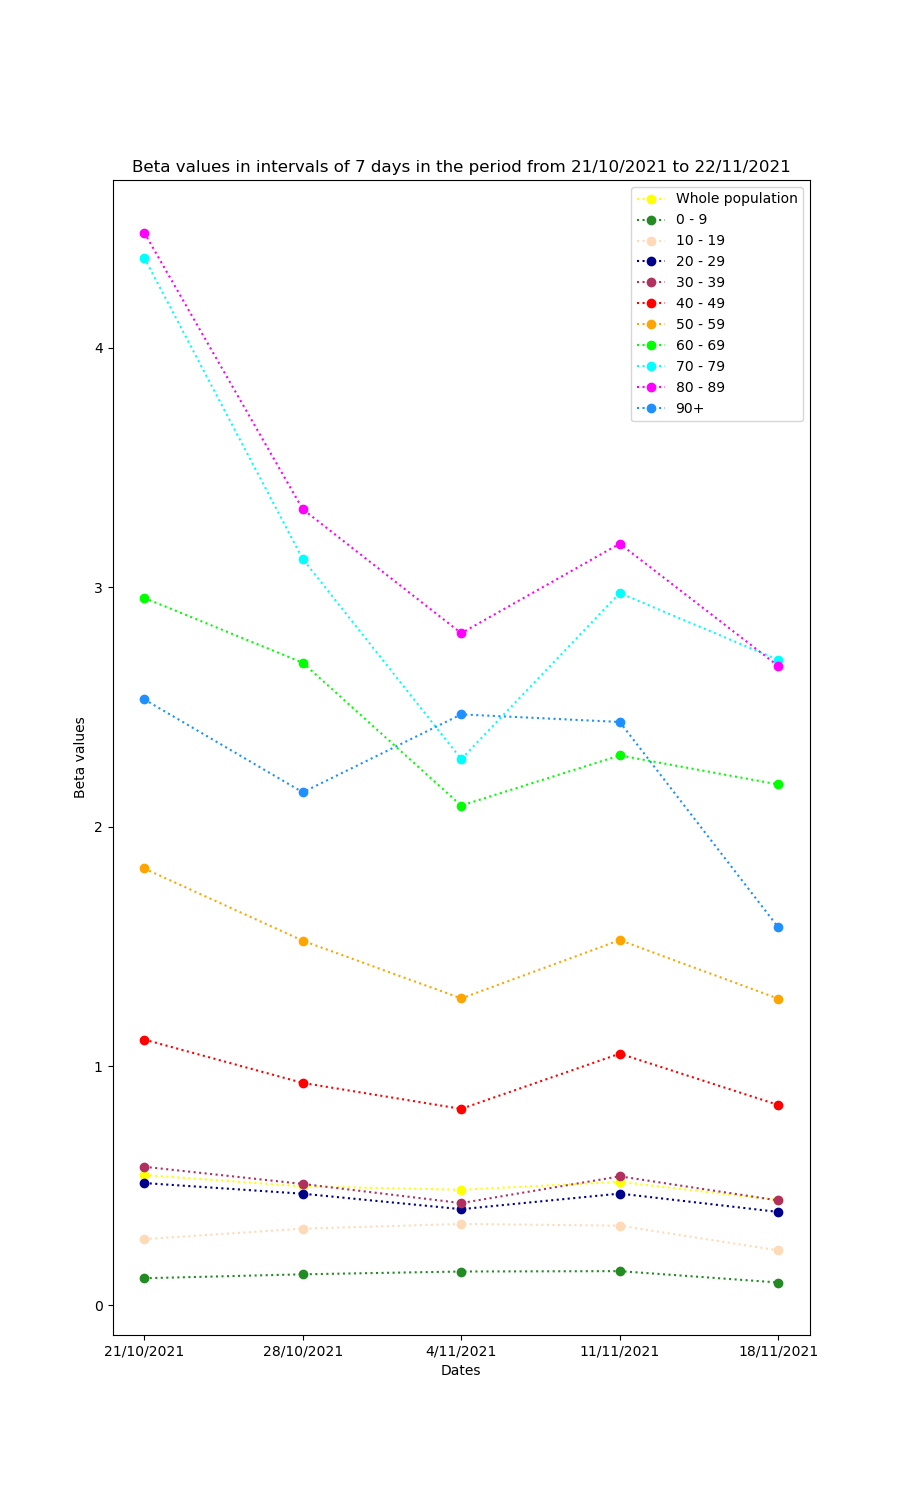

5822763 1416206.9349999996
5822763 1410491.9349999996
5822763 1403607.9349999996
5822763 1397460.9349999996
5822763 1384586.9349999996
614489 613000
614489 612514
614489 611499
614489 609881
614489 607127
681911 274393.955
681911 273788.955
681911 272560.955
681911 270827.955
681911 268185.955
782701 202013.26
782701 201202.26
782701 200228.26
782701 199535.26
782701 198096.26
686808 163356.91999999998
686808 162531.91999999998
686808 161597.91999999998
686808 160947.91999999998
686808 159207.91999999998
756048 96673.23999999999
756048 95713.23999999999
756048 94755.23999999999
756048 93995.23999999999
756048 91870.23999999999
800444 66196.29599999997
800444 65390.29599999997
800444 64582.29599999997
800444 64052.29599999997
800444 62780.29599999997
663646 32433.300000000047
663646 31940.300000000047
663646 31331.300000000047
663646 30989.300000000047
663646 30361.300000000047
564390 21979.599999999977
564390 21407.599999999977
564390 20973.599999999977
564390 20875.599999999977
564390

In [56]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials

scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/spreadsheets',
         'https://www.googleapis.com/auth/drive.file','https://www.googleapis.com/auth/drive']

creds = ServiceAccountCredentials.from_json_keyfile_name('client_secret.json', scope)

client = gspread.authorize(creds)

import os
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

interval_length = 7

start_date = #'21/10/2021'
end_date = #'22/11/2021'

plt.figure(figsize = (9, 15)) # 15, 7

# plt.title('Number of active infections between age groups in the period of 21/10/2021 - 22/11/2021')
plt.title('Beta values in intervals of ' + str(interval_length) + ' days in the period from ' + start_date + ' to ' + end_date)

for age_group_index in range(11): #11
#     age_group_index = age_group_index + 1
    sheet = client.open('Denmark Covid-19 Data').get_worksheet(age_group_index)
    
    # Modify excel data
    date_full_column = sheet.col_values(1)   # Column A
#     s_full_column = sheet.col_values(2)      # Column B
    i_full_column = sheet.col_values(3)      # Column C
#     r_full_column = sheet.col_values(4)      # Column D

    # Remove first line of each column
    date_full_column.pop(0)
#     s_full_column.pop(0)
    i_full_column.pop(0)
#     r_full_column.pop(0)
    
    start_index = date_full_column.index(start_date)
    end_index = date_full_column.index(end_date)
    
    date_column = date_full_column[start_index : end_index + 1]
    i_column = convert_to_int(i_full_column[start_index : end_index + 1])

#     First two waves
#     s_column = convert_to_int(s_full_column[start_index : end_index + 1])
#     First two waves
#     r_column = convert_to_int(r_full_column[start_index : end_index + 1])
    
    
#     x_axis = [date_column[index] for index in range(len(date_column)) if index % 4 == 0]
#     x_axis.pop(len(x_axis) - 1)
#     x_axis.append('22/11/2021')
#     print(len(date_column))
#     print(date_column)
    

#     First two waves
#     N = int(s_full_column[0]) + int(i_full_column[0]) + int(r_full_column[0])

#     Third wave
    N = get_age_group_population(age_group_index)
    
#     Third wave
    SSI_vaccinated = N * get_age_group_vac_per(age_group_index)
    
    # Finding beta
    interval_count = math.ceil(len(date_column) / interval_length)

    measure_list = []
    date_list = []

    for interval_index in range(interval_count):
        interval_start_index = interval_index * interval_length
        interval_end_index =  interval_start_index + interval_length

        interval_date_column = date_column[interval_start_index : interval_end_index]
#         interval_s_column = convert_to_int(s_column[interval_start_index : interval_end_index])
        interval_i_column = convert_to_int(i_column[interval_start_index : interval_end_index])
#         interval_r_column = convert_to_int(r_column[interval_start_index : interval_end_index])

        real_interval_length = len(interval_date_column)

        interval_x = np.array(range(real_interval_length))
        interval_y = np.log(interval_i_column)

        p = np.polyfit(interval_x, interval_y, 1)

        m = p[0]  # Slope
        b = p[1]  # Intersection at x = 0

        alpha = 1 / 14

#         Third wave
        S = N - SSI_vaccinated - interval_i_column[0]
    
        print(N, S)
        beta = (N / S) * (alpha + m)
        Re = (S / N) * (beta / alpha)

#         First two waves
#         beta = (N / interval_s_column[0]) * (alpha + m)
#         Re = (interval_s_column[0] / N) * (beta / alpha)

        measure_list.append(beta)
        date_list.append(interval_date_column[0])

#     x = np.array(range(len(r0_list)))

    plt.plot(date_list, measure_list, ':o', label = get_age_group_title(age_group_index), color = get_age_group_color(age_group_index))

#     plt.plot(date_column, i_column, '-', label = get_age_group_title(age_group_index), color = get_age_group_color(age_group_index))
    
#     plt.xticks(x_axis)

plt.legend()

plt.xlabel('Dates')
plt.ylabel('Beta values')

if not os.path.exists('./Images'):
    os.makedirs('./Images')

plt.savefig('./Images/beta_alpha.png')
plt.show()